In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, AutoModelForMaskedLM
from transformers import BertForSequenceClassification
import torch
from transformers import AdamW
from transformers import get_scheduler
from transformers import Trainer
from transformers import BertTokenizer
import numpy as np
import pandas as pd
import csv
import os


#tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese")
tokenizer = BertTokenizer.from_pretrained("G:/cloud_share/Job_posting_data/chinese-bert-wwm/")

df = pd.read_csv("F:/Data/job_posting/processed/finetune/est_sample.csv", encoding = "utf_8_sig", on_bad_lines='skip', encoding_errors='ignore')

# replace the symbol '-' to '.' in soc_code column, and convert soc_code to int
df['soc_code'] = df['soc_code'].str.replace('-', '')

# replace 'Yes' with True and NaN with False using the fillna() and astype() methods
df['true_ind'] = df['true_ind'].fillna(False).astype(bool)

c:\Users\DELL\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
c:\Users\DELL\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### The dataset is split into train, validation, and test sets as follows:

- The initial train_test_split call splits df into train_df_sample (60% of the data) and temp_df_sample (40% of the data).
- The second train_test_split call further splits temp_df_sample into valid_df_sample (50% of temp_df_sample, or 20% of the original data) and test_df_sample (50% of temp_df_sample, or 20% of the original data).
- So, the final ratio of the dataset split is 60% for training, 20% for validation, and 20% for testing.

In [ ]:
# create into train, validation and test set

from sklearn.model_selection import train_test_split
train_df_sample, temp_df_sample = train_test_split(df, test_size=0.4, random_state=42)
valid_df_sample, test_df_sample = train_test_split(temp_df_sample, test_size=0.5, random_state=42)

# export the train, validation and test set to csv
train_df_sample.to_csv('F:/Data/job_posting/processed/finetune/train_df_sample.csv', index=False, encoding = "utf_8_sig", header=True)
test_df_sample.to_csv('F:/Data/job_posting/processed/finetune/test_df_sample.csv', index=False, encoding = "utf_8_sig", header=True)
valid_df_sample.to_csv('F:/Data/job_posting/processed/finetune/valid_df_sample.csv', index=False, encoding = "utf_8_sig", header=True)


# drop index column, 'true_ind' and 'sample' columns
train_df_sample = train_df_sample.drop(['Unnamed: 0'], axis = 1)
# Generate a new column 'soc_code1' with the mapped values from 'soc_code'
train_df_sample['soc_code1'] = train_df_sample['soc_code'].map(soc_code_dict)


# drop index column, 'true_ind' and 'sample' columns
test_df_sample = test_df_sample.drop(['Unnamed: 0'], axis = 1)
# Generate a new column 'soc_code1' with the mapped values from 'soc_code' for the test set
test_df_sample['soc_code1'] = test_df_sample['soc_code'].map(soc_code_dict)

# drop index column, 'true_ind' and 'sample' columns
valid_df_sample = valid_df_sample.drop(['Unnamed: 0'], axis = 1)
# Generate a new column 'soc_code1' with the mapped values from 'soc_code' for the validation set
valid_df_sample['soc_code1'] = valid_df_sample['soc_code'].map(soc_code_dict)

In [ ]:
# Tokenize the text and convert it into input features
train_titles = train_df_sample['工作名称'].astype(str).tolist()
train_texts = train_df_sample['工作描述'].astype(str).tolist()
train_labels = train_df_sample['soc_code1'].tolist()


test_titles = test_df_sample['工作名称'].astype(str).tolist()
test_texts = test_df_sample['工作描述'].astype(str).tolist()
test_labels = test_df_sample['soc_code1'].tolist()


valid_titles = valid_df_sample['工作名称'].astype(str).tolist()
valid_texts = valid_df_sample['工作描述'].astype(str).tolist()
valid_labels = valid_df_sample['soc_code1'].tolist()

- If you have more reliable labels in your dataset, you can leverage this information to improve the performance of your model by assigning different weights to the loss function during training. This way, the model will put more emphasis on learning from the credible samples. We assign a weight of 0.5 to the first checked sample and a weight of 1.0 to the second checked sample.

In [ ]:
def assign_weight(true_ind):
    if true_ind:
        return 1.0
    else:
        return 0.5
    
# Assuming you have a column called 'true_ind' in your dataset with boolean values
# True for credible labels and False for less credible labels
train_df_sample['weight'] = train_df_sample['true_ind'].apply(assign_weight)
test_df_sample['weight'] = test_df_sample['true_ind'].apply(assign_weight)
valid_df_sample['weight'] = valid_df_sample['true_ind'].apply(assign_weight)

# Extract the weights
train_weights = train_df_sample['weight'].tolist()
valid_weights = valid_df_sample['weight'].tolist()
test_weights = test_df_sample['weight'].tolist()

* The text is based on both job posting titles and descriptions. To emphasize the importance of the job title, we repeat the title twice in the text. This way, the model will learn to give more importance to the title than the description.

In [ ]:
from torch.utils.data import Dataset

# Create the JobPostingDataset class
class JobPostingDataset(Dataset):
    def __init__(self, titles, descriptions, labels, weights, tokenizer, max_length):
        self.titles = titles
        self.descriptions = descriptions
        self.labels = labels
        self.weights = weights
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.titles)

    def __getitem__(self, idx):
        title = self.titles[idx]
        description = self.descriptions[idx]
        label = self.labels[idx]
        weight = self.weights[idx]

        # Concatenate title and description, repeat the title to give it more importance
        repeat_title = 2  # Adjust this value to control the importance of the title
        text = (title + " ") * repeat_title + description

        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )

        # Return a tuple of the input tensors, label, and weight
        return (
            encoding["input_ids"].squeeze(0),
            encoding["attention_mask"].squeeze(0),
            torch.tensor(label, dtype=torch.long),
            torch.tensor(weight, dtype=torch.float),
        )

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# Create the datasets
max_length = 512
train_dataset = JobPostingDataset(train_titles, train_texts, train_labels, train_weights, tokenizer, max_length)
valid_dataset = JobPostingDataset(valid_titles, valid_texts, valid_labels, valid_weights, tokenizer, max_length)
test_dataset = JobPostingDataset(test_titles, test_texts, test_labels, test_weights, tokenizer, max_length)

# Create the data loaders
batch_size = 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### Define an evaluate() function to compute the validation loss

In [ ]:
def evaluate(model, valid_loader, device, loss_fn):
    model.eval()
    total_loss = 0
    num_batches = 0
    with torch.no_grad():
        for batch in valid_loader:
            inputs = batch[0].to(device)
            masks = batch[1].to(device)
            labels = batch[2].to(device)
            weights = batch[3].to(device)

            logits = model(inputs, attention_mask=masks).logits
            batch_loss = loss_fn(logits, labels)
            weighted_batch_loss = batch_loss * weights
            loss = torch.mean(weighted_batch_loss)

            total_loss += loss.item()
            num_batches += 1
    return total_loss / num_batches


- Handle class imbalance by adjusting class weights in the CrossEntropyLoss criterion. To achieve this, you need to compute class weights and pass them as an argument to the CrossEntropyLoss function.
- The training loop to include early stopping based on the validation loss.

In [ ]:
# Define the model, the optimizer, and the learning rate scheduler
num_labels = len(train_df_sample['soc_code1'].unique())

model = BertForSequenceClassification.from_pretrained("G:/cloud_share/Job_posting_data/chinese-bert-wwm/", num_labels=num_labels)
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
num_epochs = 2
num_training_steps = num_epochs * len(train_loader)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights using the train_labels_np array
unique_labels = train_df_sample['soc_code1'].unique()
class_weights = compute_class_weight('balanced', classes=unique_labels, y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

Some weights of the model checkpoint at G:/Other computers/我的计算机/cloud_share/Job_posting_data/chinese-bert-wwm/ were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassifica

### Here, we start to train the model and use the validation loss to determine the best model.

In [ ]:
# The patience parameter determines how many consecutive epochs the model can go without an improvement in validation loss before stopping the training. 
# In this case, the patience is set to 3, meaning that if the validation loss does not improve for 3 consecutive epochs, the training will be stopped.
early_stopping_patience = 3
# This line initializes a counter variable called num_epochs_without_improvement that keeps track of the number of consecutive epochs without an improvement in validation loss. 
# The counter is set to 0 at the beginning of the training process and is incremented by 1 whenever there is no improvement in the validation loss. If the validation loss improves in a particular epoch, the counter is reset to 0.
num_epochs_without_improvement = 0
# During the training loop, if num_epochs_without_improvement becomes equal to or greater than early_stopping_patience, the training will be stopped. 
# This way, the training process can be terminated early when the model starts overfitting, or when there is no significant improvement in the validation loss.
best_valid_loss = float('inf')

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize lists to store losses
train_losses = []

# Utilize multiple GPUs with DataParallel
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

# Pass the computed class_weights to the CrossEntropyLoss function:
# Create a loss function that doesn't reduce the losses right away and pass class_weights
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='none')
# By incorporating class weights into the loss function, the model will pay more attention to the minority classes during training. 

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    num_batches = 0
    for batch in train_loader:
        inputs = batch[0].to(device)
        masks = batch[1].to(device)
        labels = batch[2].to(device)
        weights = batch[3].to(device)  # Assuming the weights are the 4th element in the batch

        optimizer.zero_grad()

        logits = model(inputs, attention_mask=masks).logits

        # Compute the loss for each sample
        batch_loss = loss_fn(logits, labels)

        # Multiply the loss by the corresponding weight
        weighted_batch_loss = batch_loss * weights

        # Average the weighted losses
        loss = torch.mean(weighted_batch_loss)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Add the current batch loss to the epoch_train_loss
        epoch_train_loss += loss.item()
        num_batches += 1

    # Calculate average loss for the current epoch and append it to the train_losses list
    epoch_train_loss /= num_batches
    train_losses.append(epoch_train_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_train_loss:.4f}")

    # Evaluate the model on the validation set
    valid_loss = evaluate(model, valid_loader, device, loss_fn)
    print(f"Validation Loss: {valid_loss:.4f}")

    # Save the best model based on the validation loss
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        if isinstance(model, torch.nn.DataParallel):
            model.module.save_pretrained("F:/Data/job_posting/processed/finetune/best_model")
        else:
            model.save_pretrained("F:/Data/job_posting/processed/finetune/best_model")
        num_epochs_without_improvement = 0
    else:
        num_epochs_without_improvement += 1

    # Check the stopping condition and break the loop if needed
    if num_epochs_without_improvement >= early_stopping_patience:
        print("Early stopping due to no improvement in validation loss.")
        break

Epoch 1/2, Loss: 0.6297
Validation Loss: 0.7334
Epoch 2/2, Loss: 0.6243
Validation Loss: 0.5996


- Store the training loss, use matplotlib to visualize the loss trends.

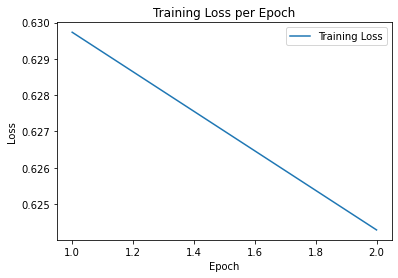

In [ ]:
plt.figure()
plt.plot(np.arange(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()

# Save the figure
plt.savefig('F:/Data/job_posting/processed/finetune/training_loss_plot.pdf', bbox_inches='tight')

### Measure the model performance and visualize it

In [ ]:
# Evaluate the performance of the model on the test set
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(device)
        masks = batch[1].to(device)

        # Resize the attention mask tensor to match the size of the inputs
        # masks.resize_(inputs.shape[0], inputs.shape[1])
    
        outputs = model(inputs, attention_mask=masks)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, axis=1).cpu().numpy()
        predictions.extend(batch_predictions)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_labels, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.3333333333333333


- We first generate some features that can be used later to visualize the model performance.

In [ ]:
# First, we need to modify the true_labels and predictions by extracting the major SOC groups from the original SOC codes.
# Create a list of SOC codes ordered by their corresponding sequential labels
ordered_soc_codes = [soc_code for soc_code, _ in sorted(soc_code_dict.items(), key=lambda item: item[1])]

# Convert test_labels and predictions back to SOC codes
test_labels_soc = np.array([ordered_soc_codes[label] for label in test_labels])
predictions_soc = np.array([ordered_soc_codes[label] for label in predictions])

# Extract major SOC groups
test_major_groups = np.array([soc_code[:2] for soc_code in test_labels_soc])
pred_major_groups = np.array([soc_code[:2] for soc_code in predictions_soc])


* Visualize the accuracy
  * To make it easier to read, the accuracy is aggregated at the major SOC groups.

In [ ]:
# Calculate accuracy for each major SOC group
major_group_accuracies = {}
unique_major_groups = np.unique(test_major_groups)
for major_group in unique_major_groups:
    major_group_indices = np.where(test_major_groups == major_group)
    major_group_accuracy = accuracy_score(test_major_groups[major_group_indices], pred_major_groups[major_group_indices])
    major_group_accuracies[major_group] = major_group_accuracy
    print(f"Major Group {major_group}: Accuracy: {major_group_accuracy:.4f}")

major_group_accuracies_df = pd.DataFrame(list(major_group_accuracies.items()), columns=['Major Group', 'Accuracy'])
major_group_accuracies_df.to_csv('F:/Data/job_posting/processed/finetune/major_group_accuracies.csv', index=False)


Major Group 11: Accuracy: 0.4583
Major Group 25: Accuracy: 0.8333


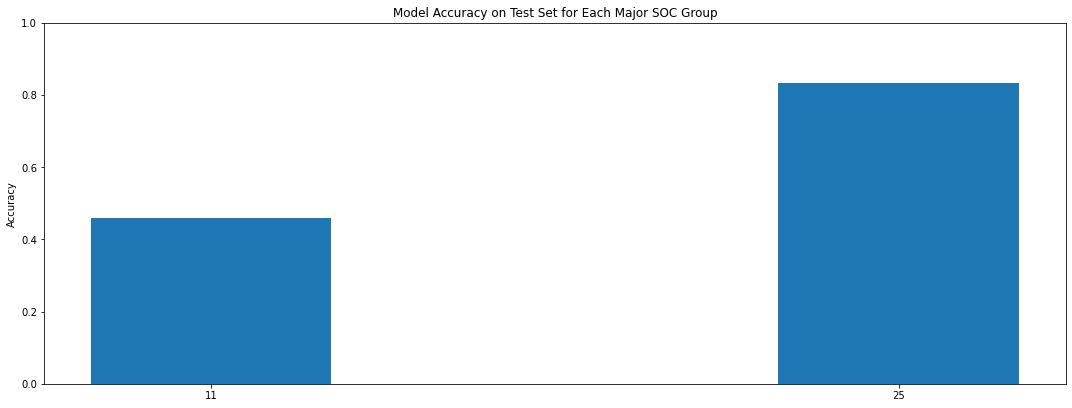

In [ ]:
# Modify the bar plot code to plot the accuracy for each major SOC group
labels = major_group_accuracies_df['Major Group'].tolist()
accuracies = major_group_accuracies_df['Accuracy'].tolist()

x = np.arange(len(labels))  # The label locations
width = 0.35  # The width of the bars

fig, ax = plt.subplots(figsize=(15, 6))
rects = ax.bar(x, accuracies, width)

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy on Test Set for Each Major SOC Group')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)  # Set y-axis limit between 0 and 1

# Function to add labels above the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

#autolabel(rects)

fig.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the top margin to avoid overlap

# Save the figure
plt.savefig('F:/Data/job_posting/processed/finetune/major_group_accuracy_plot.pdf', bbox_inches='tight')


* Confusion Matrix: A confusion matrix is a table that shows the predicted class against the true class. It helps to identify which classes the model is correctly predicting and where it's making mistakes.
  * To make it easier to read, the accuracy is aggregated at the major SOC groups.
  * A raw plot would have too many SOC labels, making it hard to interpret.

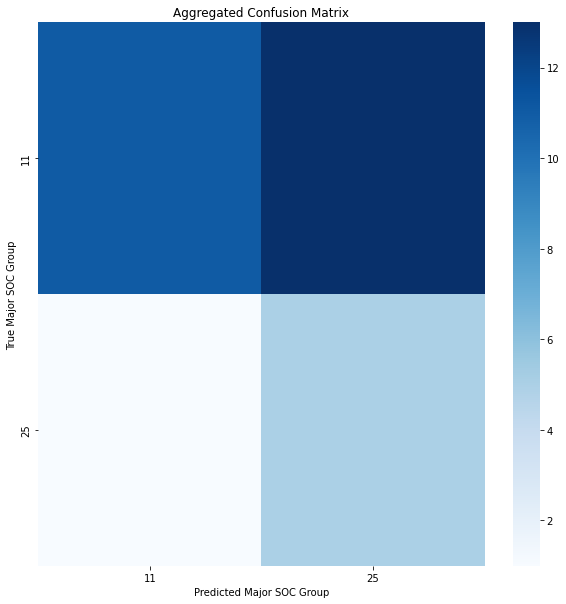

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertForSequenceClassification

# Load the best model
best_model = BertForSequenceClassification.from_pretrained("F:/Data/job_posting/processed/finetune/best_model")
best_model.to(device)
best_model.eval()

# First, we need to modify the true_labels and predictions by extracting the major SOC groups from the original SOC codes.
# Create a list of unique major SOC groups
unique_major_groups = sorted(list(set(test_major_groups).union(set(pred_major_groups))))

# Generate predictions on test set
predictions = []
true_labels = []

for batch in test_loader:
    inputs = batch[0].to(device)
    masks = batch[1].to(device)
    labels = batch[2].to(device)

    with torch.no_grad():
        logits = best_model(inputs, attention_mask=masks).logits

    preds = torch.argmax(logits, dim=-1).cpu().numpy()
    predictions.extend(preds)
    true_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
# cm = confusion_matrix(true_labels, predictions)
# Compute the aggregated confusion matrix
aggregated_cm = confusion_matrix(test_major_groups, pred_major_groups)

# Plot confusion matrix using seaborn heatmap with actual SOC codes as xticklabels and yticklabels
plt.figure(figsize=(10, 10))
sns.heatmap(aggregated_cm, annot=False, fmt='d', cmap='Blues', xticklabels=unique_major_groups, yticklabels=unique_major_groups)
plt.xlabel('Predicted Major SOC Group')
plt.ylabel('True Major SOC Group')
plt.title('Aggregated Confusion Matrix')

# Save the figure
plt.savefig('F:/Data/job_posting/processed/finetune/confusion_matrix.pdf', bbox_inches='tight')
plt.show()


- Precision-Recall Curve: The precision-recall curve shows the trade-off between precision and recall for different decision thresholds.

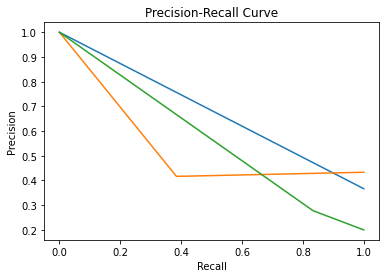

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

n_classes = len(np.unique(test_labels))

# Binarize the labels
y_true_bin = label_binarize(test_labels, classes=np.arange(n_classes))
y_pred_bin = label_binarize(predictions, classes=np.arange(n_classes))

# Create a reverse mapping dictionary to convert the sequential labels back to SOC labels
reverse_soc_code_dict = {v: k for k, v in soc_code_dict.items()}

# Plot the precision-recall curve for each class
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_bin[:, i])

    # Get the actual SOC label for the current class
    actual_soc_label = reverse_soc_code_dict[i]

    plt.plot(recall, precision, label=f"{actual_soc_label}")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
#plt.legend(loc='upper center', fontsize='xx-small', bbox_to_anchor=(0.5, -0.15), title='SOC classifcation')

# Save the figure
plt.savefig('F:/Data/job_posting/processed/finetune/precision_recall.pdf', bbox_inches='tight')
plt.show()


- Classification Report: It shows the precision, recall, F1-score, and support for each class.
  - first, we generate a table for all the SOC groups.
  - second, we visualize the statistics for the major SOC groups.

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Evaluate the model and store predictions
model.eval()

predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(device)
        masks = batch[1].to(device)
        labels = batch[2].to(device)

        logits = model(inputs, attention_mask=masks).logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(labels)

# Convert predictions and true_labels into NumPy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Map the sequential labels back to the original SOC codes
soc_predictions = [reverse_soc_code_dict[p] for p in predictions]
soc_true_labels = [reverse_soc_code_dict[l] for l in true_labels]

# Compute classification report
unique_labels = sorted(list(set(soc_true_labels).union(set(soc_predictions))))
report = classification_report(soc_true_labels, soc_predictions, labels=unique_labels, output_dict=True)

# Convert report to a pandas DataFrame
report_df = pd.DataFrame(report).transpose()

# Print the report
print(report_df)
report_df.to_csv('F:/Data/job_posting/processed/finetune/report_df.csv', index=True)

              precision    recall  f1-score    support
111010         0.000000  0.000000  0.000000  11.000000
111020         0.416667  0.384615  0.400000  13.000000
253010         0.277778  0.833333  0.416667   6.000000
accuracy       0.333333  0.333333  0.333333   0.333333
macro avg      0.231481  0.405983  0.272222  30.000000
weighted avg   0.236111  0.333333  0.256667  30.000000


c:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


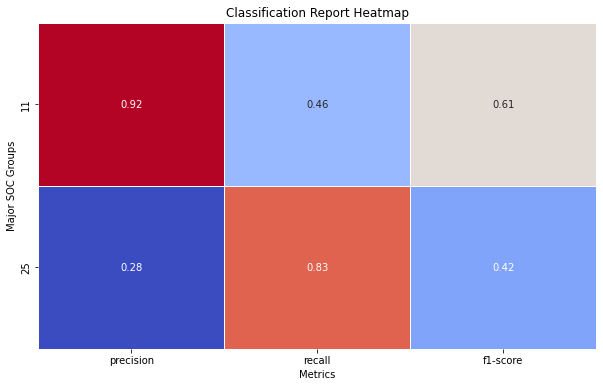

In [ ]:
# Visualize it
# This code defines a function visualize_classification_report that takes the classification report DataFrame as input and displays a heatmap. 
# The heatmap shows precision, recall, and F1-score for each class. 
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to visualize the classification report
def visualize_classification_report(report_df, heatmap_filepath='heatmap.png'):
    # Remove the 'support' column and the last row ('accuracy', 'macro avg', 'weighted avg')
    heatmap_data = report_df.iloc[:-3, :-1]

    # Sort the major SOC groups
    heatmap_data = heatmap_data.sort_index()

    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.2f', cbar=False, linewidths=0.5)
    plt.xlabel('Metrics')
    plt.ylabel('Major SOC Groups')
    plt.title('Classification Report Heatmap')

    # Save the heatmap as an image file
    plt.savefig(heatmap_filepath, bbox_inches='tight')

    # Show the heatmap
    plt.show()

from sklearn.metrics import classification_report

# Calculate the classification report
report = classification_report(test_major_groups, pred_major_groups, output_dict=True)

# Convert the report to a DataFrame
report_df = pd.DataFrame(report).transpose()

report_df['major_group'] = report_df.index

# Group the DataFrame by the major SOC groups and calculate the mean of the metrics for each group
grouped_report_df = report_df.groupby('major_group').mean()

# Call the function to visualize the classification report
visualize_classification_report(grouped_report_df, 'F:/Data/job_posting/processed/finetune/report_df.pdf')
